## Estudo de caso

Para aplicação do algoritmo do problema do caixeiro viajante, usamos como caso de uso o serviço de transporte de empregados da empresa estatal Nuclebras Equipamentos Pesados (NUCLEP). Esta empresa estatal do governo federal é vinculada ao Ministério de Minas e Energia. A NUCLEP tem como objetivos principais projetar, desenvolver, fabricar e comercializar equipamentos pesados para os setores Nuclear, Defesa, Óleo e Gás, Energia e outros. Estratégica pela tecnologia que domina, possui características únicas de suas instalações e equipamentos. Possui uma área de 1.5 milhão de metros quadrados, com 85 mil metros quadrados de área fabril. A NUCLEP está geograficamente localizada no município de Itaguaí, no Estado do Rio de Janeiro. Possui também Terminal Portuário Privativo de embarque para até 39 ton/m2. Conta com cerca de 800 empregados diretos, sem contar a mão-de-obra terceirizada. A empresa oferece transporte para os seus colaboradores em vários pontos no estado do Rio de Janeiro. Contando com 30 linhas de transporte regular que cobrem várias cidades e bairros da capital fluminense. Ainda assim, durante alguns projetos, são necessários deslocamentos de empregados em outros horários. Nesse ponto, a programação da logística de transporte da empresa, deve distribuir transporte para vários empregados a semelhança do problema do caixeiro viajante. Ou seja, a partir da rodoviária da NUCLEP os transportes partem para vários pontos do estado e retornam ao ponto de origem para os empregados iniciarem suas atividades. 

Como objeto de estudo foi selecionado uma amostragem a partir de uma das linhas. Apesar de contar com 30 linhas regulares, totalizando 575 pontos de embarque, esta segmentação ainda permite uma otimização do transporte oferecido pela empresa. Para isso foi utilizada a linha 11, de Jacarepaguá, com 25 pontos de embarque, para os testes dos algoritmos.  Esta linha em questão atende não somente Jacarepaguá, mas os bairros Anil, Barra da Tijuca, Freguesia, Pechincha, Sulacap, Tanque e Taquara. Contudo, durante os testes com o algoritmo de força bruta, tivemos que reduzir para 12 pontos de embarque. Suprimindo pontos que estavam na mesma rua, mas em números diferentes.

## Pré-processamento

Os dados de embarque informados pela NUCLEP não possuíam informações de georeferenciadas. Com isso foi necessário um trabalho de pré-processamento para tratar esta informação no modelo de algoritmo de caixeiro viajante. Foi utilizada a biblioteca de funções Geoapify para determinar as referências geográficas. Durante esta fase ainda foi necessário um refinamento nos pontos de dados informados, pois a base disponibilizada pela empresa não indicava, em alguns pontos, o número do logradouro, usando referências de construções, por proximidade, para facilitar o entendimento do empregado em relação ao ponto de embarque.

In [10]:
import pandas as pd
import requests

# Função para retornar a coordenada de um endereço
def retorne_coordenada(endereco):
    api_key = 'cf30db6de8bf4244b1626a7688b31701'
    url = f'https://api.geoapify.com/v1/geocode/search?text={endereco}&apiKey={api_key}'
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if data['features']:
            coordinates = data['features'][0]['geometry']['coordinates']
            return coordinates
    return None

# Carregar os pontos de embarque da Linha de jacarepaguá (código 55)
pontos_linha_jpa = pd.read_csv("pontos_linha_jpa.csv", sep=";", header=0, encoding="iso-8859-1")

A partir da função retorne_coordenada os dados dos pontos de embarque passaram a contar com os dados de longitude e latitude. Além de adicionar o ponto de origem da NUCLEP com o primeiro ponto do dataset criado.

In [11]:
# Adicionar o endereço da Nuclep ao dataset pontos_linha_jpa
nuclep_endereco = "NUCLEP"

# Criar um DataFrame com o endereço da Nuclep
df_nuclep = pd.DataFrame({'nmPonto': [nuclep_endereco]})

# Concatenar o DataFrame df_nuclep com pontos_linha_jpa
pontos_linha_jpa = pd.concat([df_nuclep, pontos_linha_jpa], ignore_index=True)

# Loop para ler cada registro e atribuir valores de latitude e longitude
for index, row in pontos_linha_jpa.iterrows():
    coordenadas = retorne_coordenada(row['nmPonto'])
    print(row['nmPonto'])
    print(coordenadas)
    if coordenadas:
        pontos_linha_jpa.at[index, 'latitude'] = coordenadas[1]
        pontos_linha_jpa.at[index, 'longitude'] = coordenadas[0]
    else:
        pontos_linha_jpa.at[index, 'latitude'] = None
        pontos_linha_jpa.at[index, 'longitude'] = None

NUCLEP
[-43.8288403, -22.8934134]
Avenida Geremario Dantas, 1083
[-43.3514921, -22.9365601]
Estrada de Jacarepagua, 7300
[-43.3389721, -22.9455302]
Estrada do Tindiba, 1148
[-43.3651905, -22.9284232]
Estrada dos Tres Rios, 223
[-43.3416453, -22.9392088]
Rua Marechal Jose Bevilaqua, 240
[-43.36932, -22.923261]
Rua Tirol, 356
[-43.3385247, -22.940199]
Rua Bacairis, 106
[-43.372278, -22.920207]
Avenida dos Mananciais, 771
[-43.3855556, -22.9170584]
Avenida Alberico Diniz, 1645
[-43.392382, -22.886949]
Estrada do Engenho Dagua, 2
[-43.349606, -22.955552]
Estrada do Catonho, 650
[-43.3798223, -22.9070657]
Estrada Coronel Pedro Correa, 1470
[-43.3872686, -22.9717692]


A parte final do pré-processamento é a criação de uma matriz de distância. Onde cada linha na matriz representa um dos pontos de embarque e o ponto de origem, normalmente indentificado como depot=0 (zero). E no par linha/coluna nesta matriz são armazenadas as distâncias, o que infere que a diagonal principal da matriz apresente todos os valores zerados. Para fazer esta matriz foi utilizado uma função do geoapify routematrix. Para atender ao formato de entrada desta função, os dados de longitude e latitude foram consolidados em uma matriz coordenadas.

In [12]:
# Função para calcular a distância entre os pontos de embarque e gerar a matriz de distâncias
def calcular_distancias(coordenadas):
    api_key = 'cf30db6de8bf4244b1626a7688b31701'
    url = 'https://api.geoapify.com/v1/routematrix?apiKey=' + api_key
    payload = {
        "mode": "drive",
        "sources": [{"location": coord} for coord in coordenadas],
        "targets": [{"location": coord} for coord in coordenadas]
    }

    response = requests.post(url, json=payload)
    if response.status_code == 200:
        data = response.json()
        if 'sources_to_targets' in data:
            distancias = []
            for linha in data['sources_to_targets']:
                distancias.append([item['distance'] for item in linha])
            return distancias
    return None

def criar_modelo(): 
    # Montar um vetor de coordenadas com o par latitude e longitude vindo do dataset pontos_linha_jpa
    coordenadas = []
    for index, row in pontos_linha_jpa.iterrows():
        if pd.notnull(row['longitude']) and pd.notnull(row['latitude']):
            coordenadas.append([row['longitude'], row['latitude']])
            
    # Criar a matriz de distâncias
    matriz_distancia = calcular_distancias(coordenadas)

    # Exibir a matriz de distância quebrando em nova linha cada conjunto
    for linha in matriz_distancia:
        print(linha)
        
    return {"matriz_distancia": matriz_distancia, "depot": 0}    

## Força Bruta

Para a simulação de um algoritmo que atenda ao problema do caixeiro viajante, faremos uma abordagem inicial em força bruta. Nesta estratégia deve-se considerar todas as permutações possíveis dos pontos do itinerário, representadas pelos pontos de embarque, sejam analisadas. Reconhecidamente por este método o custo computacional pode ser exponencial, forçando limitarmos o número de pontos usados na iteração. Nos testes executados, tivemos um desempenho aceitável até 13 pontos de embarque, acima deste valor o algoritmo ficou inviável.


Primeiramente é definida a função calcular_distancia_rota que incrementa as distâncias dos pontos a partir de uma rota proposta passada em parâmetro, retornando o total percorrido incluindo o ponto de origem no início e o retorno a origem no final da rota.  

In [13]:
from itertools import permutations
import time

# Função para calcular a distância de uma rota
def calcular_distancia_rota(rota, matriz_distancia):
    
    distancia = 0
    for i in range(len(rota) - 1):
        distancia += matriz_distancia[rota[i]][rota[i + 1]]
    # Add return to the depot
    distancia += matriz_distancia[rota[-1]][rota[0]]
    return distancia

Para o algoritmo de força bruta propriamente, a função forca_bruta executa um procedimento iterativo, a partir da matriz de distância, com todas as permutações de cada um dos pontos de embarque. Para a permutação foi utilizado a biblioteca permutations do Python. Com isso é calculado a distância de cada uma dessas rotas (usando a função calcular_distancia_rota), comparando os resultados obtidos até determinar a rota com a menor distância. A função time() contabiliza o tempo de processamento.

In [14]:
# Função para calcular a melhor rota e a menor distância usando força bruta
def forca_bruta(data):
    num_pontos = len(data["matriz_distancia"])
    depot = data["depot"]
    pontos = list(range(num_pontos))
    pontos.remove(depot)  # Excluir o ponto de origem das permutações

    menor_distancia = float("inf")
    melhor_rota = None

    for perm in permutations(pontos):
        rota_corrente = [depot] + list(perm) + [depot]  # Início e fim do ponto de origem
        distancia_corrente = calcular_distancia_rota(rota_corrente, data["matriz_distancia"])
        if distancia_corrente < menor_distancia:
            menor_distancia = distancia_corrente
            melhor_rota = rota_corrente

    return melhor_rota, menor_distancia

def main():
    # Carregar matriz de distâncias
    data = criar_modelo()
    
    # Medir o tempo inicial
    inicio = time.time()
    melhor_rota, menor_distancia = forca_bruta(data)
    
    # Medir o tempo final
    fim = time.time()
    tempo_execucao = fim - inicio

    print(f"Melhor rota: {' -> '.join(map(str, melhor_rota))}")
    print(f"Distância mínima: {menor_distancia} metros")
    print(f"Tempo de execução: {tempo_execucao:.2f} segundos")

main()

[0, 66247, 68609, 63384, 68761, 62987, 68349, 62067, 60015, 55725, 72007, 59450, 68050]
[65338, 0, 2362, 2517, 3033, 3245, 2102, 4594, 6422, 10300, 4284, 6024, 7050]
[68355, 3020, 0, 5537, 1877, 6265, 946, 7614, 9442, 13317, 1818, 9044, 7461]
[62270, 2129, 4491, 0, 4643, 728, 4231, 1253, 3081, 8027, 6413, 3748, 9179]
[66478, 1143, 1608, 3660, 0, 4388, 1348, 5737, 7565, 11440, 2530, 7167, 7833]
[61680, 4204, 6566, 1133, 6718, 0, 6306, 525, 2353, 7016, 8488, 2737, 11254]
[67409, 2074, 1248, 4591, 931, 5319, 0, 6668, 8496, 12371, 3461, 8098, 8764]
[61529, 3583, 5945, 1454, 6097, 1055, 5685, 0, 1742, 6491, 7867, 2212, 10633]
[59215, 4914, 7276, 2785, 7428, 2386, 7016, 2850, 0, 6182, 9198, 1838, 12302]
[55503, 10589, 12951, 8063, 13103, 7665, 12691, 6749, 5946, 0, 14873, 4131, 15936]
[72478, 3174, 2996, 5691, 3667, 6419, 2736, 7768, 9596, 13474, 0, 9198, 6263]
[60316, 5805, 8167, 3938, 8319, 3539, 7907, 2618, 2219, 5276, 10089, 0, 12855]
[65422, 9347, 11525, 7222, 12196, 6823, 11265, 7348, 

## Algoritmo Guloso

Uma opção para resolver o problema de caixeiro viajante é utilizar uma heurística do "Caminho Mais Perto Primeiro" (Nearest Neighbor). Trata-se de um algoritmo guloso. Começando pelo caminho inicial onde busca-se o ponto de embarque mais próximo que ainda não foi visitado. E assim sucessivamente até atender a todos os pontos de embarque e retornar para a origem (depot=0), no caso em questão, da rodoviária da NUCLEP.

Para esta abordagem, faremos uso da mesma matriz de distância já previamente calculada. Nessa função é necessário manter o registro dos pontos de embarque já visitados e assim fazer a iteração no conjunto ainda a ser visitado.

In [15]:
# Função para calcular a distância de uma rota usando o algoritmo do vizinho mais próximo
def vizinho_mais_proximo(data):
    num_pontos = len(data["matriz_distancia"])
    depot = data["depot"]
    matriz_distancia = data["matriz_distancia"]

    # Inicializa a rota começando pelo depósito
    ponto_corrente = depot
    rota = [ponto_corrente]
    distancia_total = 0

    # Conjunto de pontos não visitados
    nao_visitado = set(range(num_pontos))
    nao_visitado.remove(depot)

    while nao_visitado:
        # Encontra o ponto mais próximo não visitado
        ponto_maisperto = None
        menor_distancia = float('inf')
        for ponto in nao_visitado:
            if matriz_distancia[ponto_corrente][ponto] < menor_distancia:
                menor_distancia = matriz_distancia[ponto_corrente][ponto]
                ponto_maisperto = ponto

        distancia_total += menor_distancia
        rota.append(ponto_maisperto)
        ponto_corrente = ponto_maisperto
        nao_visitado.remove(ponto_maisperto)

    # Retorna ao depósito
    distancia_total += matriz_distancia[ponto_corrente][depot]
    rota.append(depot)

    return rota, distancia_total

# Carregar matriz de distâncias
data = criar_modelo()

# Medir o tempo inicial
inicio = time.time() * 1000
rota, distancia_total = vizinho_mais_proximo(data)

# Medir o tempo final
fim = time.time() * 1000
tempo_execucao = fim - inicio

print(f"Rota: {rota}")
print(f"Distância total: {distancia_total} metros")
print(f"Tempo de execução: {tempo_execucao:.2f} segundos")

[0, 66247, 68609, 63384, 68761, 62987, 68349, 62067, 60015, 55725, 72007, 59450, 68050]
[65338, 0, 2362, 2517, 3033, 3245, 2102, 4594, 6422, 10300, 4284, 6024, 7050]
[68355, 3020, 0, 5537, 1877, 6265, 946, 7614, 9442, 13317, 1818, 9044, 7461]
[62270, 2129, 4491, 0, 4643, 728, 4231, 1253, 3081, 8027, 6413, 3748, 9179]
[66478, 1143, 1608, 3660, 0, 4388, 1348, 5737, 7565, 11440, 2530, 7167, 7833]
[61680, 4204, 6566, 1133, 6718, 0, 6306, 525, 2353, 7016, 8488, 2737, 11254]
[67409, 2074, 1248, 4591, 931, 5319, 0, 6668, 8496, 12371, 3461, 8098, 8764]
[61529, 3583, 5945, 1454, 6097, 1055, 5685, 0, 1742, 6491, 7867, 2212, 10633]
[59215, 4914, 7276, 2785, 7428, 2386, 7016, 2850, 0, 6182, 9198, 1838, 12302]
[55503, 10589, 12951, 8063, 13103, 7665, 12691, 6749, 5946, 0, 14873, 4131, 15936]
[72478, 3174, 2996, 5691, 3667, 6419, 2736, 7768, 9596, 13474, 0, 9198, 6263]
[60316, 5805, 8167, 3938, 8319, 3539, 7907, 2618, 2219, 5276, 10089, 0, 12855]
[65422, 9347, 11525, 7222, 12196, 6823, 11265, 7348, 

## Resultado comparativo

No comparativo entre as duas abordagens: força bruta e um algoritmo guloso, para a amostra em questão, revelou-se um resultado de melhor rota exatamente igual. Ambos os métodos determinaram o mesmo caminho. O que não necessariamente pode ser uma regra para outras amostragens. No entanto, a dificuldade do processamento em força bruta praticamente limita as escolhas por este método para conjunto de dados bem reduzidos. 


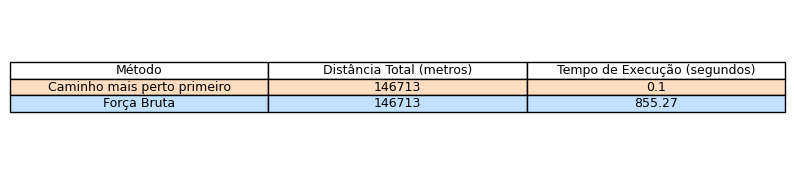

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Dados coletados dos dois códigos
data = {
    'Método': ['Caminho mais perto primeiro', 'Força Bruta'],
    'Distância Total (metros)': [146713, 146713],
    'Tempo de Execução (segundos)': [0.10, 855.27]
}

# Criar DataFrame
df_resultados = pd.DataFrame(data)
# Plotar tabela com cores
fig, ax = plt.subplots(figsize=(10, 2))  # Ajustar o tamanho da figura conforme necessário
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df_resultados.values, colLabels=df_resultados.columns, cellLoc='center', loc='center')

# Adicionar cores às células
colors = ['#FFDDC1', '#C1E1FF']
for i in range(len(df_resultados)):
    for j in range(len(df_resultados.columns)):
        cell = table[(i + 1, j)]
        cell.set_facecolor(colors[i % len(colors)])

plt.show()